# Script to train a model for NMD Scanner

In [14]:
## Train NMD efficiency Predictor upon RandomForestRegressor

recreate the train.ipynb from the NMD eff paper: https://github.com/hjkng/nmdeff/blob/main/train.ipynb

In [15]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [16]:
# load dataset
df= pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')
df.shape

(4257, 49)

In [17]:
'''
Description of columns
        downstream_exon_count (as Downstream exon count): The number of exons downstream of the PTC
        last_exon (as Last exon): 1 if the PTC is located on the last exon; 0 otherwise
        PTC_to_start_codon (as Dist PTC to start codon): The distance between the PTC to start codon
        dist_to_stop_codon (as Dist PTC to normal stop codon): The distance between the PTC and normal stop codon
        PTC_exon_length (as PTC-containing exon length): The length of the PTC-containing exon
        PTC_to_intron (as Dist PTC to downstream EJ): The distance between the PTC and downstream exon junction
        upstream_exon_count (as Upstream exon count): The number of exons upstream of the PTC
        mRNA_half_life (as mRNA half-life): The half-life of mRNA
        50nt_to_last_EJ (as Last 50nt penultimate exon): 1 if the PTC is located on the last exon; 0 otherwise
        LOEUF (as LOEUF): Gene-level degree of mutational constraints
        AF: (as Allele frequency): Allele frequency in gnomAD database
        5UTR_length: (as 5'UTR length) : The length of 5'UTR
        3UTR_length: (as 3'UTR length) : The length of 3'UTR
        Transcript_length: (as Transcript length) : The length of the transcript
'''

# we expect to match names of columns to your datasets
cols = ['downstream_exon_count', 'last_exon', 'PTC_to_start_codon',
        'dist_to_stop_codon', 'PTC_exon_length', 'PTC_to_intron','upstream_exon_count',
        'mRNA_half_life','50nt_to_last_EJ','LOEUF', 'AF', '5UTR_length', '3UTR_length', 'Transcript_length']

df[cols].head(1)

,downstream_exon_count,last_exon,PTC_to_start_codon,dist_to_stop_codon,PTC_exon_length,PTC_to_intron,upstream_exon_count,mRNA_half_life,50nt_to_last_EJ,LOEUF,AF,5UTR_length,3UTR_length,Transcript_length
0,1,0,996,369,89,84,7,592.689818,0,0.737,0.0,356,370,1722


In [18]:
df[cols].isnull().sum()

downstream_exon_count      0
last_exon                  0
PTC_to_start_codon         0
dist_to_stop_codon         0
PTC_exon_length            0
PTC_to_intron              0
upstream_exon_count        0
mRNA_half_life             0
50nt_to_last_EJ            0
LOEUF                    130
AF                         0
5UTR_length                0
3UTR_length                0
Transcript_length          0
dtype: int64

In [19]:
df = df.loc[df['LOEUF'].notnull()].reset_index(drop=True)
df.shape

(4127, 49)

In [20]:
regr = RandomForestRegressor(max_features = 3, n_estimators=10000, n_jobs=-1)

In [21]:
# applying cross-valiation method for evaluation
scores = cross_val_score(regr, df[cols], df['NMD_efficiency'], cv=5)
print(f'r2: {np.mean(scores):5f}, std: {np.std(scores):5f}')

r2: 0.437300, std: 0.069766


In [22]:
X = df[cols]
y = df['NMD_efficiency']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [23]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)
print(f'r2: {regr.score(X_test, y_test):5f}')

r2: 0.459461


### Importance of trained randomforest regressor

In [24]:
importance_df = pd.DataFrame({'feature':regr.feature_names_in_, 
                              'importance': regr.feature_importances_})

importance_df 

,feature,importance
0,downstream_exon_count,0.134151
1,last_exon,0.079527
2,PTC_to_start_codon,0.093250
3,dist_to_stop_codon,0.084038
4,PTC_exon_length,0.089694
5,PTC_to_intron,0.085973
6,upstream_exon_count,0.050794
7,mRNA_half_life,0.060516
8,50nt_to_last_EJ,0.020068
9,LOEUF,0.065048


In [25]:
# Save the trained model
pickle.dump(regr, open('nmd_eff_predictor', 'wb'))

### NMD efficiency

- Was genau bedeutet die Efficiency nochmal?
- Wie ist der Wertebereich?
- Hast du ein Histogramm?


--- Beschreibung von NMD_efficiency ---
count    4257.000000
mean        1.014920
std         1.265065
min        -1.670936
25%        -0.023687
50%         0.788255
75%         1.930212
max         6.839370
Name: NMD_efficiency, dtype: float64
Anzahl fehlender Werte: 0

Wertebereich: -1.671 bis 6.839


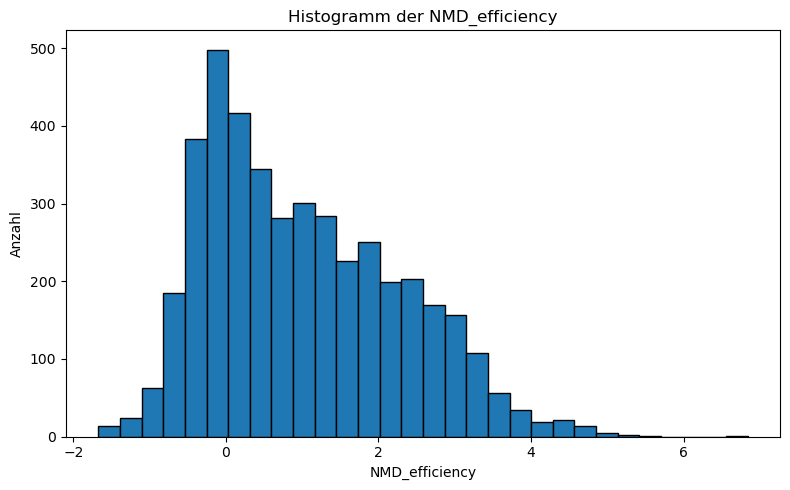

In [26]:
# Lade den TCGA Benchmark Datensatz
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Beschreibung der Verteilung (inkl. NaNs)
print("\n--- Beschreibung von NMD_efficiency ---")
print(df["NMD_efficiency"].describe())
print(f"Anzahl fehlender Werte: {df['NMD_efficiency'].isnull().sum()}")

# 2. Wertebereich
min_eff = df["NMD_efficiency"].min()
max_eff = df["NMD_efficiency"].max()
print(f"\nWertebereich: {min_eff:.3f} bis {max_eff:.3f}")

# 3. Histogramm anzeigen
plt.figure(figsize=(8, 5))
df["NMD_efficiency"].hist(bins=30, edgecolor='black')
plt.title("Histogramm der NMD_efficiency")
plt.xlabel("NMD_efficiency")
plt.ylabel("Anzahl")
plt.grid(False)
plt.tight_layout()
plt.show()

# Train a model for NMD Scanner

Fragen zum Model:
- Tue ich TCGA und MMRF Output joinen und gejoint als Input für mein Model oder getrennt?
- Welche Spalte ist mein y?

In [46]:
df.shape

(18426, 71)

In [27]:
# merge NMD_Scanner Output von TCGA mit dem NMD_efficiency score vom Original TCGA Benchmark
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

# ✅ Inspect result
print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

Merged shape: (4246, 72)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  end_variant  NMD_efficiency
0  ENST00000000412        8942472      8942472        0.389934
1  ENST00000000442       64314869     64314869        0.425091
2  ENST00000002165      143497446    143497446        1.165452
3  ENST00000002829       50174085     50174085        1.631418
4  ENST00000003084      117627525    117627525        0.999051


In [28]:
df_merged['NMD_efficiency'].isnull().sum()

np.int64(0)

In [29]:
df_merged

,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,nmd_escape,utr3_length,utr5_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_less_than_150nt_to_start,ptc_exon_length,NMD_efficiency
0,ENST00000000412,.,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,...,False,159,1457,7.0,4.0,2.0,654.0,False,167.0,0.389934
1,ENST00000000442,.,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,...,False,777,225,7.0,4.0,2.0,699.0,False,171.0,0.425091
2,ENST00000002165,.,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,...,False,86,895,7.0,6.0,0.0,1203.0,False,310.0,1.165452
3,ENST00000002829,.,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,...,False,960,289,19.0,3.0,15.0,306.0,False,63.0,1.631418
4,ENST00000003084,.,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,...,False,1557,70,27.0,21.0,5.0,3471.0,False,249.0,0.999051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4241,ENST00000607197,.,138404495,138413078,ATGGCCGAGCCGCTCCAGCCAGACCCCGGGGCGGCCGAGGACGCGG...,618,138404495,138413078,ATGGCCGAGCCGCTCCAGCCAGACCCCGGGGCGGCCGAGGACGCGG...,618,...,False,9119,273,4.0,3.0,0.0,456.0,False,9318.0,-0.267592
4242,ENST00000607484,.,33697652,33711686,ATGGCGGCCAGCCGGTACCGGCGTTTTCTTAAGCTCTGTGAGGAAT...,381,33697652,33711686,ATGGCGGCCAGCCGGTACCGGCGTTTTCTTAAGCTCTGTGAGGAAT...,381,...,False,14,889,4.0,2.0,1.0,183.0,False,75.0,-0.049774
4243,ENST00000608796,.,128276340,128288716,CTGGACCCTCTTGCGCCATTGAACCCCCTGATCCGGGGGCCTCGGA...,513,128276340,128288716,CTGGACCCTCTTGCGCCATTGAACCCCCTGATCCGGGGGCCTCGGA...,513,...,True,274,119,5.0,4.0,0.0,138.0,True,339.0,-0.407414
4244,ENST00000610020,.,92299073,92380874,ATGGCGGACTTCGCTGGGCCGTCTTCTGCCGGCCGCAAGGCCGGGG...,1839,92299073,92380874,ATGGCGGACTTCGCTGGGCCGTCTTCTGCCGGCCGCAAGGCCGGGG...,1839,...,False,15046,15,13.0,11.0,1.0,1794.0,False,150.0,0.537657



--- Beschreibung von NMD_efficiency ---
count    4246.000000
mean        1.013731
std         1.265040
min        -1.670936
25%        -0.023829
50%         0.788079
75%         1.928361
max         6.839370
Name: NMD_efficiency, dtype: float64
Anzahl fehlender Werte: 0

Wertebereich: -1.671 bis 6.839


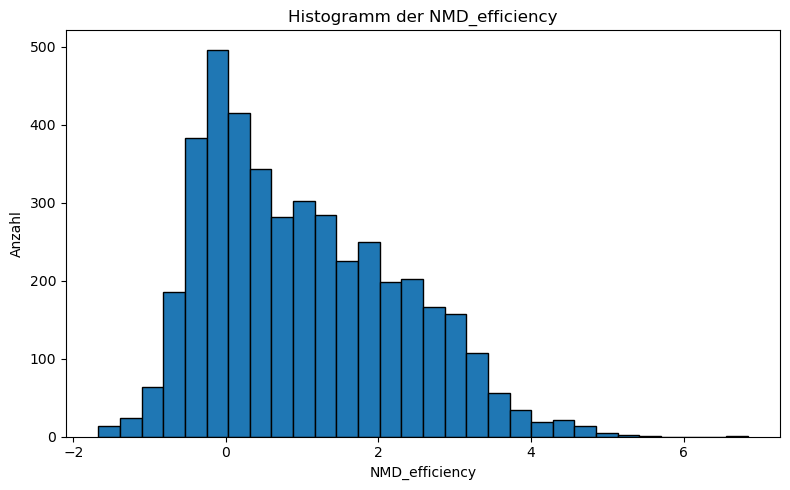

In [30]:
# 1. Beschreibung der Verteilung (inkl. NaNs)
print("\n--- Beschreibung von NMD_efficiency ---")
print(df_merged["NMD_efficiency"].describe())
print(f"Anzahl fehlender Werte: {df_merged['NMD_efficiency'].isnull().sum()}")

# 2. Wertebereich
min_eff = df_merged["NMD_efficiency"].min()
max_eff = df_merged["NMD_efficiency"].max()
print(f"\nWertebereich: {min_eff:.3f} bis {max_eff:.3f}")

# 3. Histogramm anzeigen
plt.figure(figsize=(8, 5))
df_merged["NMD_efficiency"].hist(bins=30, edgecolor='black')
plt.title("Histogramm der NMD_efficiency")
plt.xlabel("NMD_efficiency")
plt.ylabel("Anzahl")
plt.grid(False)
plt.tight_layout()
plt.show()

In [31]:
# only 9 rows missing between original TCGA dataset and joined dataset

In [32]:
df_merged.shape

(4246, 72)

In [33]:
# add distance to stop codon feature --> will it be a problem later on when I want to include it in AbExp?
df_merged["stop_codon_distance_nmd"] = df_merged["ref_first_stop_pos"] - df_merged["alt_first_stop_pos"]

In [34]:
# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
        'stop_codon_distance_nmd'] 

df_merged[cols].head(1)

,start_loss,stop_loss,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,utr3_length,utr5_length,alt_transcript_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_exon_length,stop_codon_distance_nmd
0,False,False,False,False,False,False,False,False,159,1457,2450.0,7.0,4.0,2.0,654.0,167.0,177.0


In [35]:
df_merged[cols].isnull().sum()

start_loss                    0
stop_loss                     0
nmd_last_exon_rule            0
nmd_50nt_penultimate_rule     0
nmd_long_exon_rule            0
nmd_start_proximal_rule       0
nmd_single_exon_rule          0
nmd_escape                    0
utr3_length                   0
utr5_length                   0
alt_transcript_length        10
total_exon_count              0
upstream_exon_count           0
downstream_exon_count         0
ptc_to_start_codon            3
ptc_exon_length               0
stop_codon_distance_nmd      10
dtype: int64

In [36]:
# drop null values
df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df_merged.shape

(18426, 71)

In [37]:
df_merged[cols].isnull().sum()

start_loss                   0
stop_loss                    0
nmd_last_exon_rule           0
nmd_50nt_penultimate_rule    0
nmd_long_exon_rule           0
nmd_start_proximal_rule      0
nmd_single_exon_rule         0
nmd_escape                   0
utr3_length                  0
utr5_length                  0
alt_transcript_length        0
total_exon_count             0
upstream_exon_count          0
downstream_exon_count        0
ptc_to_start_codon           0
ptc_exon_length              0
stop_codon_distance_nmd      0
dtype: int64

In [47]:
df_merged.shape

(4233, 73)

In [38]:
regr = RandomForestRegressor(max_features = 3, n_estimators=10000, n_jobs=-1)

In [39]:
# applying cross-valiation method for evaluation
scores = cross_val_score(regr, df_merged[cols], df_merged['NMD_efficiency'], cv=5)
print(f'r2: {np.mean(scores):5f}, std: {np.std(scores):5f}')

r2: 0.325522, std: 0.028412


In [40]:
X = df_merged[cols]
y = df_merged['NMD_efficiency']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [41]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)
print(f'r2: {regr.score(X_test, y_test):5f}')

r2: 0.369412


In [42]:
# Importance of trained randomforest regressor

In [43]:
importance_df = pd.DataFrame({'feature':regr.feature_names_in_, 
                              'importance': regr.feature_importances_})

importance_df 

,feature,importance
0,start_loss,0.000000
1,stop_loss,0.000000
2,nmd_last_exon_rule,0.000000
3,nmd_50nt_penultimate_rule,0.003285
4,nmd_long_exon_rule,0.000000
5,nmd_start_proximal_rule,0.007521
6,nmd_single_exon_rule,0.000340
7,nmd_escape,0.013975
8,utr3_length,0.088002
9,utr5_length,0.093469


In [44]:
# Save the trained model
pickle.dump(regr, open('nmd_eff_predictor2', 'wb'))

# Analyse der NaN Werte in df

In [ ]:
# Prüfen, ob dieselben Zeilen NaNs in allen 4 Spalten haben
mask_upstream = df["upstream_exon_count"].isnull()
mask_total = df["total_exon_count"].isnull()
mask_downstream = df["downstream_exon_count"].isnull()
mask_ptc_exon_length = df["ptc_exon_length"].isnull()

# Vergleichen, ob alle Masken identisch sind
same_rows = (
    (mask_upstream == mask_total) &
    (mask_total == mask_downstream) &
    (mask_downstream == mask_ptc_exon_length)
)

print("Alle 4 Spalten NaN in denselben Zeilen:", same_rows.all())  # Sollte True sein

In [ ]:
# Zeige nur die Zeilen mit NaNs in exon-relevanten Spalten
df[mask_total][["transcript_id", "total_exon_count", "nmd_single_exon_rule"]].head()

In [ ]:
# Bedingung: Alle vier Spalten sind NaN
mask = df[[
    "upstream_exon_count",
    "total_exon_count",
    "downstream_exon_count",
    "ptc_exon_length"
]].isnull().all(axis=1)

# Zeige alle betroffenen Zeilen (komplett)
pd.set_option("display.max_columns", None)  # Zeige alle Spalten
pd.set_option("display.max_rows", 100)      # Falls viele Zeilen, begrenze ggf.
df_nan_rows = df[mask]
df_nan_rows

In [ ]:
# check if all rows have start_loss or stop_loss = False, in that case, transcript information will be NaN

all_both_false = (df_nan_rows["start_loss"] == False) & (df_nan_rows["stop_loss"] == False)

print("Anzahl der Zeilen mit NaNs in den vier Spalten:", len(df_nan_rows))
print("Anzahl dieser Zeilen, bei denen start_loss UND stop_loss False sind:", all_both_false.sum())

# Optional: Zeige nur die Zeilen, wo das NICHT zutrifft (zur Kontrolle)
df_nan_rows[~all_both_false]

In [ ]:
# check if alt_is_premature = FALSE in all cases
all_false = (df_nan_rows["alt_is_premature"] == False).all()
print("alt_is_premature überall False:", all_false)

In [ ]:
# Wahrscheinlich kommen die 217 Null-Werte in total_exon_count, downstream_exon_count, upstream_exon_count und ptc_exon_length daher, dass alt_is_premature = False ist. 
# Jetzt will ich mir die anderen columns mit den Null Werten anschauen. Dafür extrahiere ich alle Zeilen wo alt_transcript_length = NaN da hier die höchste Zahl ist, und schaue nach,
# ob die anderen NaN Werte hier drin enthalten sind.

In [ ]:
df[cols].isnull().sum()

In [ ]:
# check if ptc_to_start_codon = NaN is because we do not have a PTC

# Check, ob ptc_to_start_codon NaN ist, weil kein PTC vorhanden ist
ptcstartcodon_df = df["ptc_to_start_codon"].isnull()
df_na = df[ptcstartcodon_df].copy()

# Überprüfen, ob überall alt_is_premature == False
all_false = (df_na["alt_is_premature"] == False).all()
print("alt_is_premature überall False:", all_false)

# Zähle wie oft False bzw. True vorkommt
value_counts = df_na["alt_is_premature"].value_counts(dropna=False)
print("\nVerteilung von alt_is_premature bei fehlendem ptc_to_start_codon:")
print(value_counts)

In [ ]:
# Maske für Zeilen mit NaN in alt_transcript_length
mask_alt_transcript_na = df["alt_transcript_length"].isnull()

# Neues DataFrame mit diesen 1854 Zeilen
df_alt_na = df[mask_alt_transcript_na].copy()

# Anzahl dieser Zeilen (sollte 1854 sein)
print("Anzahl Zeilen mit alt_transcript_length NaN:", df_alt_na.shape[0])

# Prüfen, wie viele davon auch andere Spalten als NaN haben
null_counts_in_alt_na = df_alt_na[[
    "total_exon_count",
    "upstream_exon_count",
    "downstream_exon_count",
    "ptc_exon_length",
    "ptc_to_start_codon",
    "stop_codon_distance_nmd"
]].isnull().sum()

print("NaN-Werte innerhalb der 1854 alt_transcript_length-NaNs:")
print(null_counts_in_alt_na)

# Wie viele der 1854 haben alt_is_premature == False?
false_premature_count = df_alt_na["alt_is_premature"] == False
print("Anzahl alt_is_premature == False innerhalb der 1854:", false_premature_count.sum())

In [ ]:
# Grund für alt_transcript_length = NaN ist weil cds_in_transcript = False ist, d.h. das CDS konnte nicht im Transkript festgestellt werden

# Anzahl der Fälle, in denen cds_in_transcript == False
cds_false_count = df[df["cds_in_transcript"] == False].shape[0]

# Anzahl der Fälle, in denen alt_transcript_length == NaN
alt_len_nan_count = df["alt_transcript_length"].isnull().sum()

# Anzahl der Fälle, in denen cds_in_transcript == False und alt_transcript_length == NaN
both_condition_count = df[(df["cds_in_transcript"] == False) & (df["alt_transcript_length"].isnull())].shape[0]

print(f"cds_in_transcript == False: {cds_false_count}")
print(f"alt_transcript_length == NaN: {alt_len_nan_count}")
print(f"Beides gleichzeitig: {both_condition_count}")
print(f"Vollständige Übereinstimmung: {cds_false_count == alt_len_nan_count == both_condition_count}")

# Create my own Model